In [1]:
from __future__ import print_function
%matplotlib inline 
# make plots show in ipython notebook

import numpy as np
import os, sys
import logging
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pandas as pd
import pylab
import itertools
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# Get logging information

In [2]:
# Load two files
target_file = pd.read_table("target_collection", compression = None, header = 0, sep = '\t')
logger.info(("target file loaded. " + str(np.shape(target_file)[0]) + " documents."))
query_file = pd.read_table("queries_val", compression = None, header = 0, sep = '\t')
logger.info(("query file loaded. " + str(np.shape(query_file)[0]) + " queries."))

INFO:root:target file loaded. 17784 documents.
INFO:root:query file loaded. 1000 queries.


In [3]:
# Initialize global variables
vectorizer = None
tfidf = None # TF-IDF model
tokens_list = None # List of tokens used by TF-IDF
target_weights = None
stemmer = PorterStemmer()

In [4]:
if sys.version_info.major == 2:
    punct_table = string.maketrans('','')
else:
    punct_table = str.maketrans('','', string.punctuation)

In [5]:
def cleantext(text):
    """Clean string from punctuation and capitals."""
    lowers = text.lower()
    if sys.version_info.major == 2:
        no_punctuation = lowers.translate(punct_table, string.punctuation)
    else:
        no_punctuation = lowers.translate(punct_table)
    return no_punctuation

In [6]:
def tokenize(text):
    """Transform string to list of stemmed tokens."""
    tokens = nltk.word_tokenize(text)
    stemmed = (stemmer.stem(token) for token in tokens)
    return stemmed

In [7]:
def getTFIDF():
    """Return cached TFIDF model."""
    global vectorizer
    global tokens_list
    global tfidf
    global target_weights
    
    if tfidf is None:
        #vectorizer = CountVectorizer(tokenizer=tokenize, stop_words = stopwords.words('english'))
        vectorizer = CountVectorizer(tokenizer=tokenize, stop_words = set('for a of the and to in'.split()))
        target_counts = vectorizer.fit_transform(target_file['txt_caption'])
        tokens_list = vectorizer.get_feature_names()
        tfidf = TfidfTransformer()
        target_weights = tfidf.fit_transform(target_counts)
    return tfidf

In [9]:
def querySimilarity(query):
    """rank all targets for each query"""
    tfidf = getTFIDF()
    query_weight = tfidf.transform(vectorizer.transform([query]))
    # inner product (cosine similarity) for query and all targets' vectors
    sim = query_weight.dot(target_weights.transpose(copy =True))
    # sort similarity scores decreasingly
    sim1000_pos = np.argsort(-sim.toarray())[0][:1000]
    sim1000_score = sim.toarray()[0][sim1000_pos]
    return [sim1000_pos, sim1000_score]

In [10]:
def getAveragePrecision(query_img_id, best, cutoff):
    """compute AP for each query at recall@cutoff"""
    if len(best) < 1: # this query has no match
        return 0.0
    else:
        tp_series = np.where(np.asarray([target_file['img_id'][x] for x in best[:cutoff]]) == query_img_id)[0]
        tp_tpfp = [(i_no + 1.0)/(i + 1.0) for i_no, i in enumerate(tp_series)]# precision = (tp/(tp+fp))
        tpfn = len(np.where(target_file['img_id'] == query_img_id)[0]) #tp+fn
        averPrec = sum(tp_tpfp)/tpfn
        return averPrec

In [11]:
def precAndRec(query_img_id, best):
    """compute precision and recall for each query"""
    if len(best) < 1: # this query has no match
        return None
    else:
        tp_series = np.where(np.array([target_file['img_id'][x] for x in best]) == query_img_id)[0]
        tp_tpfp = [(i_no + 1.0)/(i + 1.0) for i_no, i in enumerate(tp_series)]# precision = (tp/(tp+fp))
        tpfn = len(np.where(target_file['img_id'] == query_img_id)[0]) #tp+fn， denominator for recall
        tmp = 0
        precRecall_arr = [0.0] * 11
        # computation of precision based on 11 standard recall levels
        if len(tp_series) < 1:
            return precRecall_arr
        i= 0
        for tmp in range(len(tp_tpfp)):
            while (i/10.0) <= ((tmp + 1.0) / tpfn):
                precRecall_arr[i] = tp_tpfp[tmp]
                i += 1
        return np.array(precRecall_arr)

In [12]:
def meanResult(model_name):
    """compute average of AP and precision-recall for all queries"""
    sum_averagePrecision = []
    sum_precision = np.array([0.0] * 11)
    for row in query_file.itertuples():
        query, query_img_id = row[3], row[2]
        best = querySimilarity(query)
        sum_averagePrecision.append(getAveragePrecision(query_img_id, best[0], 1000))
        prec = precAndRec(query_img_id, best[0])
        sum_precision += prec
    
    meanAP = np.mean(sum_averagePrecision)
    print("Mean Average Precision of " + model_name + " is: ", str(meanAP))
    pylab.plot(np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), sum_precision / 1000)
    pylab.xlabel('recall')
    pylab.ylabel('precision')
    pylab.title(model_name)

Mean Average Precision of tfidf model is:  0.239710977855


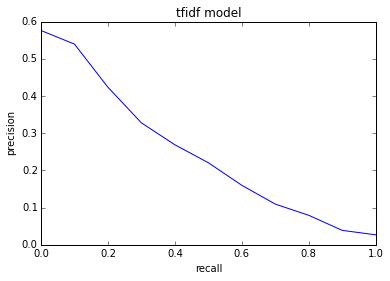

In [13]:
meanResult("tfidf model") # it takes long time, be patient

In [19]:
def searchPairs(outFileName):
    outFile = open(outFileName, 'w')
    for row in query_file.itertuples():
        query, query_img_id = row[3], row[2]
        best = querySimilarity(query)   # best[0] is the row number for document, best[1] is the similarity score
        if best:
            target_doc = target_file['txt_caption'][best[0][:1000]]
            target_key = target_file['img_id'][best[0][:1000]]
            d = {'query': [query]*1000, 'target': target_doc, 'match': [query_img_id]*1000 == target_key, 'score':best[1][:1000]}
            d = pd.DataFrame(d)
            for row1 in d.itertuples():
                toWrite = str(row1[1]) + '\t' + row1[2] + '\t' + row1[4] + '\t' + str(row1[3]) + '\n'
                outFile.write(toWrite)
    outFile.close() 

In [20]:
searchPairs('tfidfResult.txt') # if you want to save all query-document-match-similarity results, run this line.

In [14]:
test_queries = ["Two people in a group of four are holding awards as they pose for a picture.",\
                "A woman in a red dress is posing with an axe.",\
                "Two soccer plays stand next to each other with soccer balls in front of them."]
test_keys = ["CbnA_e6AW6U7Ycoa", "PaqtOaYmQmXkqW2i", "IPcFtNL-7EQ6Z0yu"]

In [17]:
def testExamples(query, key):
    best = querySimilarity(query)
    target_doc = target_file['txt_caption'][best[0][:1000]]
    target_key = target_file['img_id'][best[0][:1000]]
    d = {'target':target_doc, 'match':[key]*1000 == target_key, 'score':best[1][:1000]}
    d = pd.DataFrame(d)
    for i in range(20):
        print(d['match'].iloc[i])
        print(d['score'].iloc[i])
        print(query)
        print(d['target'].iloc[i])
        print()
    return d

In [18]:
test1 = testExamples(test_queries[0], test_keys[0])

True
0.572735869397
Two people in a group of four are holding awards as they pose for a picture.
A group of people are standing together and holding awards.

False
0.521277915014
Two people in a group of four are holding awards as they pose for a picture.
Four people posing for a picture.

True
0.520325483463
Two people in a group of four are holding awards as they pose for a picture.
Four people are holding awards and standing in a line in front of a blue wall.

False
0.518147674243
Two people in a group of four are holding awards as they pose for a picture.
Two people holding up an award as people clap.

False
0.513688954735
Two people in a group of four are holding awards as they pose for a picture.
A picture of people awarding a dog.

False
0.491055927813
Two people in a group of four are holding awards as they pose for a picture.
A group of four people are posing for the camera.

False
0.485555177329
Two people in a group of four are holding awards as they pose for a picture.
A gr

In [19]:
test2 = testExamples(test_queries[1], test_keys[1])

True
0.694185745514
A woman in a red dress is posing with an axe.
There is a woman in red sitting with an axe in her hand.

False
0.616629709965
A woman in a red dress is posing with an axe.
A man standing and holding an axe.

True
0.56993237994
A woman in a red dress is posing with an axe.
A woman with long dark hair in a red dress sits next to rubble holding an axe.

False
0.565926153612
A woman in a red dress is posing with an axe.
A red haired woman in a dress is posing.

False
0.561321180827
A woman in a red dress is posing with an axe.
There is a man cutting a tree with an axe.

False
0.554020604994
A woman in a red dress is posing with an axe.
A woman in a red dress poses for a picture.

False
0.480473256419
A woman in a red dress is posing with an axe.
A picture of a woman in a red dress posing for the camera.

False
0.475935173001
A woman in a red dress is posing with an axe.
A man holding an axe and a newspaper.

False
0.472466002859
A woman in a red dress is posing with an a

In [20]:
test3 = testExamples(test_queries[2], test_keys[2])

True
0.695884606341
Two soccer plays stand next to each other with soccer balls in front of them.
Two men are standing with soccer balls.

False
0.635899079375
Two soccer plays stand next to each other with soccer balls in front of them.
A picture of two men playing soccer.

False
0.603938020265
Two soccer plays stand next to each other with soccer balls in front of them.
Two men play soccer inside.

False
0.577289591215
Two soccer plays stand next to each other with soccer balls in front of them.
Two people playing a game of soccer.

False
0.552159747415
Two soccer plays stand next to each other with soccer balls in front of them.
A soccer player in a green uniform during soccer match dribbling the ball.

False
0.547280349084
Two soccer plays stand next to each other with soccer balls in front of them.
Men playing a game of soccer.

False
0.546933023314
Two soccer plays stand next to each other with soccer balls in front of them.
A picture of two soccer players.

False
0.539521280787
